# Import the required libraries

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost
from catboost import CatBoostClassifier
#import h2o
#from h2o.estimators.gbm import H2OGradientBoostingEstimator
%matplotlib inline 

# Read the datasets

In [13]:
data = pd.read_csv("../train.csv")

data.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
4,189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct


In [14]:
test = pd.read_csv("../test.csv")

test.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare
0,213284604,10.5,924,42,2.4486,148,2/1/2020 0:38,2/1/2020 0:53,6.83454,79.8750,6.77490,79.8840,289.27
1,213286352,10.5,4249,20,0.0000,91,2/1/2020 1:02,2/1/2020 2:13,6.91168,79.8723,6.55091,79.9706,1912.70
2,213293973,10.5,1552,255,2.6588,23,2/1/2020 5:02,2/1/2020 5:28,6.92145,79.8478,6.90539,79.8989,394.00
3,213294622,10.5,462,16,0.0000,198,2/1/2020 5:30,2/1/2020 5:38,6.77433,79.9416,6.80401,79.9407,154.32
4,213298687,10.5,814,392,12.3692,69,2/1/2020 7:00,2/1/2020 7:14,6.97968,79.9130,6.98875,79.8914,147.47


# count of each class

In [15]:
data["label"].value_counts()

correct      15495
incorrect     1681
Name: label, dtype: int64

# Data Cleaning

# Check for duplicated rows, then remove

print (sum(data.duplicated()))

data[data.duplicated()]

print(data.shape)

data.drop_duplicates(inplace=True)

print (data.shape)

Check the data type of each column and do necessary changes

In [16]:
data.dtypes

tripid                         int64
additional_fare              float64
duration                     float64
meter_waiting                float64
meter_waiting_fare           float64
meter_waiting_till_pickup    float64
pickup_time                   object
drop_time                     object
pick_lat                     float64
pick_lon                     float64
drop_lat                     float64
drop_lon                     float64
fare                         float64
label                         object
dtype: object

In [17]:
data["pickup_time"] = pd.to_datetime(data["pickup_time"])
data["drop_time"] = pd.to_datetime(data["drop_time"])
data["label"] = data["label"].apply(lambda x: 1 if x=="correct" else 0)

test["pickup_time"] = pd.to_datetime(test["pickup_time"])
test["drop_time"] = pd.to_datetime(test["drop_time"])

# Null Value handling

In [18]:
data[data["label"]==1].isna().describe()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
count,15495,15495,15495,15495,15495,15495,15495,15495,15495,15495,15495,15495,15495,15495
unique,1,2,2,2,2,2,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,15495,15442,15442,15442,15442,15442,15495,15495,15495,15495,15495,15495,15495,15495


In [19]:
data[data["label"]==0].isna().describe()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
count,1681,1681,1681,1681,1681,1681,1681,1681,1681,1681,1681,1681,1681,1681
unique,1,2,2,2,2,2,1,1,1,1,1,1,2,1
top,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,1681,1532,1532,1532,1532,1532,1681,1681,1681,1681,1681,1681,1544,1681


In [20]:
test.isna().describe()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare
count,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576
unique,1,1,1,1,1,1,1,1,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576,8576


Fill the Cells with NaN with the mean value of that column

In [21]:
data["additional_fare"].fillna(data["additional_fare"].mean() , inplace=True)
data["duration"].fillna(data["duration"].median() , inplace=True)
data["meter_waiting"].fillna(data["meter_waiting"].median() , inplace=True)
data["meter_waiting_fare"].fillna(data["meter_waiting_fare"].median() , inplace=True)
data["meter_waiting_till_pickup"].fillna(data["meter_waiting_till_pickup"].median() , inplace=True)
data["fare"].fillna(data["fare"].median() , inplace=True)

# EDA

Let's Explore the distribution of each featue

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f81178c56a0>,
      dtype=object)

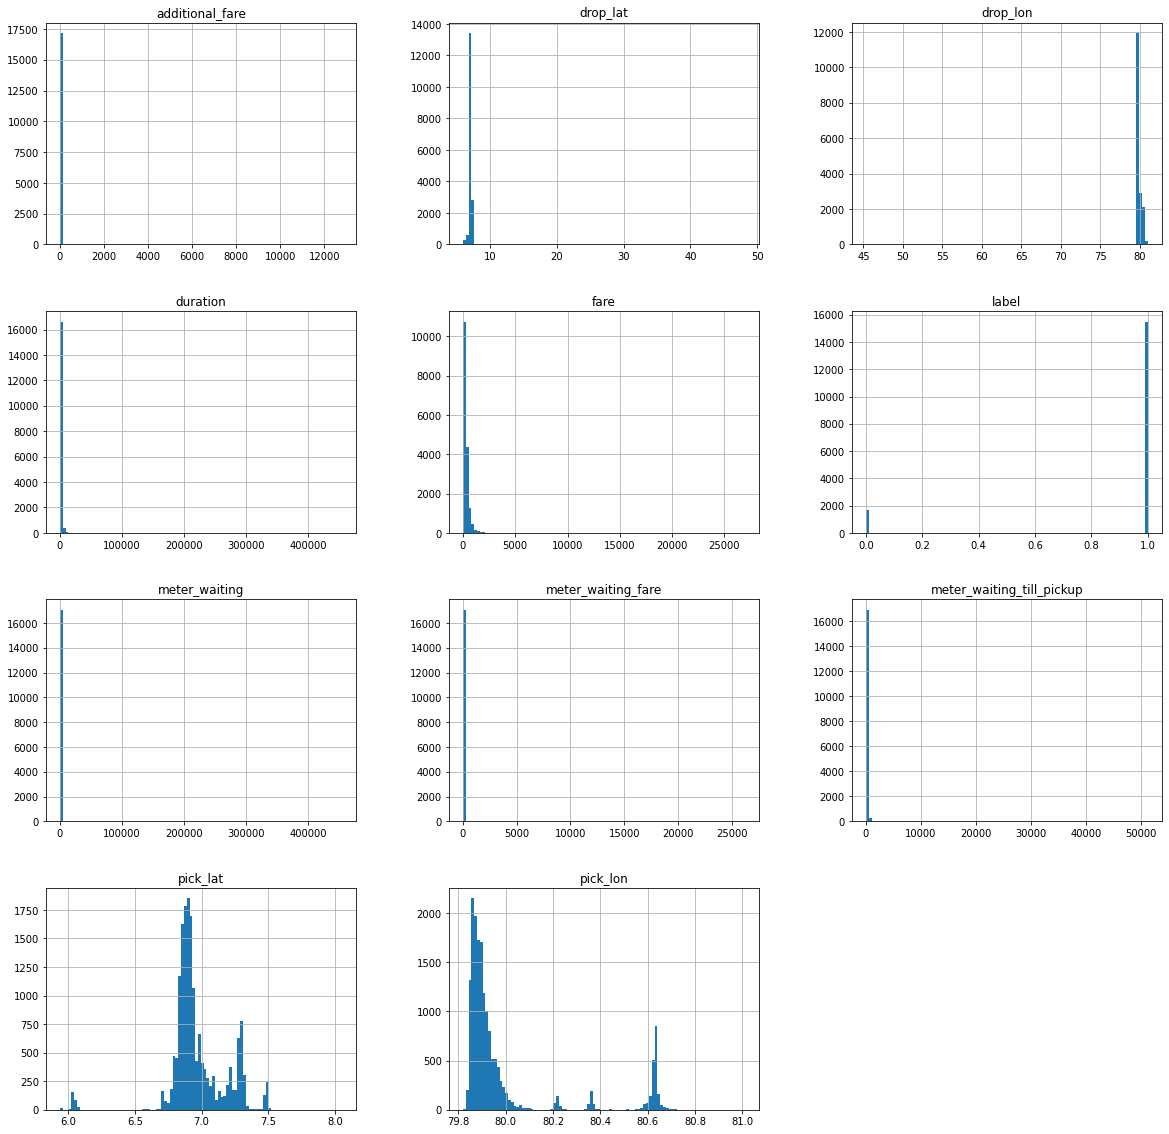

In [22]:
data.iloc[:,1:].hist(figsize=(20,20) , bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8116b8eda0>,
      dtype=object)

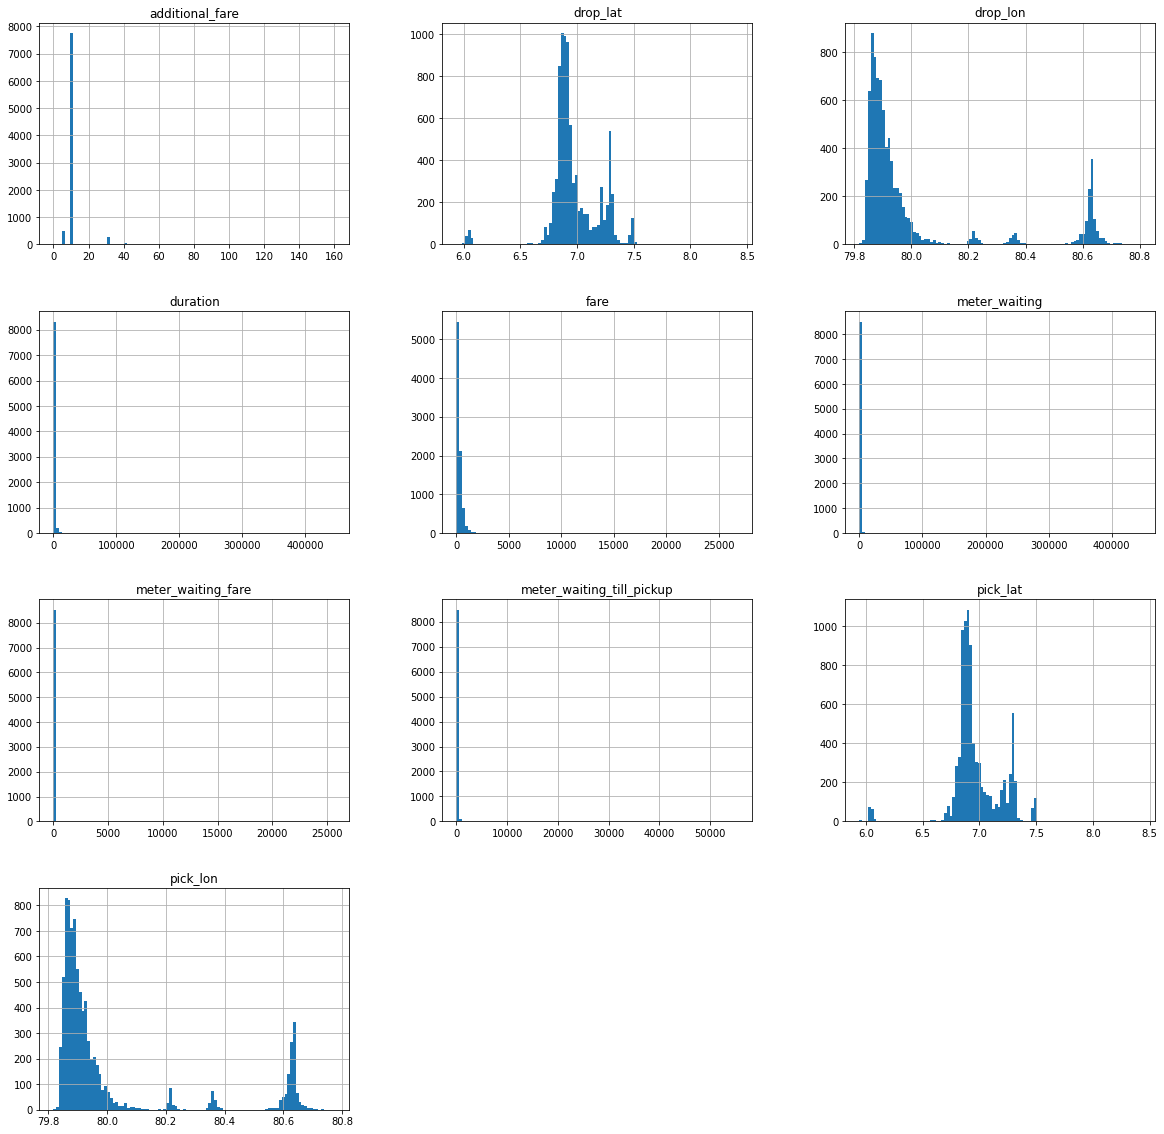

In [23]:
test.iloc[:,1:].hist(figsize=(20,20) , bins=100)

In [24]:
data.corr()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
tripid,1.000000,0.019026,-0.019479,-0.016670,-0.017077,-0.017600,0.027357,0.027085,0.005512,0.028426,-0.014823,0.062490
additional_fare,0.019026,1.000000,-0.000772,0.197600,0.199599,0.002355,0.009072,0.000616,0.004635,0.001533,0.315152,-0.039219
duration,-0.019479,-0.000772,1.000000,0.969786,0.968666,0.040664,-0.027068,-0.025526,-0.016011,-0.013666,0.864950,-0.106107
meter_waiting,-0.016670,0.197600,0.969786,1.000000,0.999474,0.030511,-0.016185,-0.014200,-0.010151,-0.007958,0.869804,-0.101232
meter_waiting_fare,-0.017077,0.199599,0.968666,0.999474,1.000000,0.029978,-0.015044,-0.012496,-0.009470,-0.006869,0.864756,-0.097298
meter_waiting_till_pickup,-0.017600,0.002355,0.040664,0.030511,0.029978,1.000000,0.011177,0.016219,0.006858,0.010907,0.045569,-0.031585
pick_lat,0.027357,0.009072,-0.027068,-0.016185,-0.015044,0.011177,1.000000,0.522473,0.560466,0.340161,-0.024595,-0.029237
pick_lon,0.027085,0.000616,-0.025526,-0.014200,-0.012496,0.016219,0.522473,1.000000,0.307313,0.654917,-0.035036,-0.037713
drop_lat,0.005512,0.004635,-0.016011,-0.010151,-0.009470,0.006858,0.560466,0.307313,1.000000,-0.414566,-0.015573,-0.012781
drop_lon,0.028426,0.001533,-0.013666,-0.007958,-0.006869,0.010907,0.340161,0.654917,-0.414566,1.000000,-0.014879,-0.030347


# Remove outliers

Let's Plot boxplot to see there any outliers

column_names = list(data.columns)
column_names.remove("pickup_time")
column_names.remove("drop_time")
column_names.remove("tripid")
column_names.remove("label")
for i in column_names:
    sn.boxplot(data[i])
    plt.show()

Q1 = data.drop(["pickup_time","drop_time","tripid","label"] , axis=1).quantile(0.05)
Q3 = data.drop(["pickup_time","drop_time","tripid","label"] , axis=1).quantile(0.95)
IQR = Q3 - Q1
print(IQR)

print((data.drop(["pickup_time","drop_time","tripid","label"] , axis=1) < (Q1 - 1.5 * IQR)) |(data.drop(["pickup_time","drop_time","tripid","label"] , axis=1) > (Q3 + 1.5 * IQR)))

data = data[~((data.drop(["pickup_time","drop_time","tripid","label"] , axis=1) < (Q1 - 1.5 * IQR)) |(data.drop(["pickup_time","drop_time","tripid","label"] , axis=1) > (Q3 + 1.5 * IQR))).any(axis=1)]

data.shape

# Feature Engineering

Create new features from the existing features
    pickup_time_minuts - number of minutes past from 12 AM 
    Distance - Euclidean distance using longitude and latitude

In [25]:
data["pickup_time_minuts"] = data["pickup_time"].apply(lambda x: int(x.strftime("%M"))+int(x.strftime("%H"))*60)
data["distance"] = ((data["pick_lat"]-data["drop_lat"])**2 + (data["pick_lon"] - data["drop_lon"])**2 )**0.5

#data["drop_time_minuts"] = data["drop_time"].apply(lambda x: int(x.strftime("%M"))+int(x.strftime("%H"))*60)
#data["pickup_day"] = data["pickup_time"].apply(lambda x: int(x.strftime("%w")))
#data["drop_day"] = data["drop_time"].apply(lambda x: int(x.strftime("%w")))
#data["pickup_month"] = data["pickup_time"].apply(lambda x: int(x.strftime("%m")))
#data["drop_month"] = data["drop_time"].apply(lambda x: int(x.strftime("%m")))



test["pickup_time_minuts"] = test["pickup_time"].apply(lambda x: int(x.strftime("%M"))+int(x.strftime("%H"))*60)
test["distance"] = ((test["pick_lat"]-test["drop_lat"])**2 + (test["pick_lon"] - test["drop_lon"])**2 )**0.5

#test["drop_time_minuts"] = test["drop_time"].apply(lambda x: int(x.strftime("%M"))+int(x.strftime("%H"))*60)
#test["pickup_day"] = test["pickup_time"].apply(lambda x: int(x.strftime("%w")))
#test["drop_day"] = test["drop_time"].apply(lambda x: int(x.strftime("%w")))
#test["pickup_month"] = test["pickup_time"].apply(lambda x: int(x.strftime("%m")))
#test["drop_month"] = test["drop_time"].apply(lambda x: int(x.strftime("%m")))


    date_diff - difference of drop and pickup time in seconds

In [26]:
data["date_diff"] = data['drop_time'] - data['pickup_time']
data['date_diff']=data['date_diff']/np.timedelta64(1,'s')

test["date_diff"] = test['drop_time'] - test['pickup_time']
test['date_diff']=test['date_diff']/np.timedelta64(1,'s')

data["tot_time"] = data["meter_waiting_till_pickup"] + data["meter_waiting"]
test["tot_time"] = test["meter_waiting_till_pickup"] + test["meter_waiting"]
data["tot_fare"] = data["additional_fare"] + data["meter_waiting_fare"] + data["fare"]
test["tot_fare"] = test["additional_fare"] + test["meter_waiting_fare"] + test["fare"]


In [31]:
data.drop(["tripid" , "pickup_time" , "drop_time" , "drop_lon" , "drop_lat" , "pick_lon" , "pick_lat"], axis=1, inplace=True)

test.drop(["tripid" , "pickup_time" , "drop_time"  , "drop_lon" , "drop_lat" , "pick_lon" , "pick_lat"], axis=1, inplace=True)

# Get the featue importance

Feature ranking:
1. fare 5 (0.194440)
2. duration 1 (0.162081)
3. distance 8 (0.154995)
4. pickup_time_minuts 7 (0.153364)
5. meter_waiting 2 (0.092417)
6. meter_waiting_till_pickup 4 (0.065254)
7. label 6 (0.062385)
8. meter_waiting_fare 3 (0.060131)
9. additional_fare 0 (0.054934)


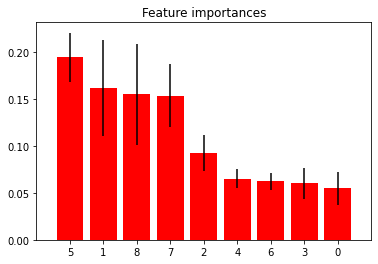

In [36]:
tree_cls = RandomForestClassifier()

tree_cls.fit(data.drop(["label"],axis=1),data["label"])

importances = tree_cls.feature_importances_
std = np.std([tree.feature_importances_ for tree in tree_cls.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(data.shape[1]-1):
    print("%d. %s %d (%f)" % (f + 1,data.columns[indices[f]], indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(data.shape[1]-1), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(data.shape[1]-1), indices)
plt.xlim([-1, data.shape[1]-1])
plt.show()

data.drop(["meter_waiting_till_pickup" , "meter_waiting"], axis=1, inplace=True)

test.drop(["meter_waiting_till_pickup" , "meter_waiting"], axis=1, inplace=True)

data.drop(["meter_waiting_fare" , "additional_fare"], axis=1, inplace=True)

test.drop(["meter_waiting_fare" , "additional_fare"], axis=1, inplace=True)


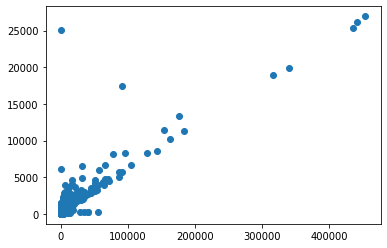

In [32]:
plt.scatter(data["date_diff"] , data["fare"])

# Splitting the dataset

In [41]:
X = data.drop(["label"],axis=1)
scale = MinMaxScaler()

X = scale.fit_transform(X)

Y = data["label"]
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

print (y_train.value_counts())
print(y_test.value_counts())


1    12371
0     1369
Name: label, dtype: int64
1    3124
0     312
Name: label, dtype: int64


# Training and Prediction

# XGBoost Classifier

xg_clf = xgboost.XGBClassifier(n_estimators = 1000)

cv = cross_validate(xg_clf, X,Y,cv=4, scoring= {'f1' , 'accuracy' , 'recall' , 'precision'}, return_train_score=True)

print (cv['train_accuracy'])
print ("Mean Accuracy(Training) : " , cv['train_accuracy'].mean())

print (cv['train_recall'])
print ("Mean Recall Score(Training) : " ,cv['train_recall'].mean())

print (cv['train_precision'])
print ("Mean Precision Score(Training) : " ,cv['train_precision'].mean())

print (cv['train_f1'])
print ("Mean F1 Score(Training) : " ,cv['train_f1'].mean())

print (cv['test_accuracy'])
print ("Mean Accuracy Score(Testing) : " ,cv['test_accuracy'].mean())

print (cv['test_recall'])
print ("Mean recall Score(Testing) : " ,cv['test_recall'].mean())

print (cv['test_precision'])
print ("Mean Precision Score(Testing) : " , cv['test_precision'].mean())

print (cv['test_f1'])
print ("Mean F1 Score(Testing) : " ,cv['test_f1'].mean())

clf = xgboost.XGBClassifier(n_estimators = 1000)

clf.fit(X,Y)

pred = clf.predict(X_test)

print (confusion_matrix(y_test,pred))

print (f1_score(y_test,pred))

pred_1 = clf.predict(X_train)

print (confusion_matrix(y_train,pred_1))

print (f1_score(y_train,pred_1))

t_pred = clf.predict(scale.transform(test))

test_sub = pd.read_csv("../sample_submission.csv")

test_sub["prediction"] = t_pred

test_sub.to_csv("../late_sub_2.csv" , index=False)

# Random Forest Classifier

In [51]:
rf1_clf = RandomForestClassifier(n_estimators=1000 )

cv = cross_validate(rf1_clf, X,Y,cv=4, scoring= {'f1' , 'accuracy' , 'recall' , 'precision'}, return_train_score = True)

print (cv['train_accuracy'])
print ("Mean Accuracy(Training) : " , cv['train_accuracy'].mean())

print (cv['train_recall'])
print ("Mean Recall Score(Training) : " ,cv['train_recall'].mean())

print (cv['train_precision'])
print ("Mean Precision Score(Training) : " ,cv['train_precision'].mean())

print (cv['train_f1'])
print ("Mean F1 Score(Training) : " ,cv['train_f1'].mean())

print (cv['test_accuracy'])
print ("Mean Accuracy Score(Testing) : " ,cv['test_accuracy'].mean())

print (cv['test_recall'])
print ("Mean recall Score(Testing) : " ,cv['test_recall'].mean())

print (cv['test_precision'])
print ("Mean Precision Score(Testing) : " , cv['test_precision'].mean())

print (cv['test_f1'])
print ("Mean F1 Score(Testing) : " ,cv['test_f1'].mean())

[1. 1. 1. 1.]
Mean Accuracy(Training) :  1.0
[1. 1. 1. 1.]
Mean Recall Score(Training) :  1.0
[1. 1. 1. 1.]
Mean Precision Score(Training) :  1.0
[1. 1. 1. 1.]
Mean F1 Score(Training) :  1.0
[0.94247788 0.95202608 0.95062878 0.94317653]
Mean Accuracy Score(Testing) :  0.9470773171867723
[0.97780072 0.99509551 0.98890036 0.98967209]
Mean recall Score(Testing) :  0.9878671703722779
[0.95923018 0.95373577 0.95775    0.94946743]
Mean Precision Score(Testing) :  0.9550458463831784
[0.96842643 0.97397676 0.97307595 0.96915297]
Mean F1 Score(Testing) :  0.9711580269709124


In [44]:
rf_clf = RandomForestClassifier(n_estimators=1000)

rf_clf.fit(X_train,y_train)

pred = rf_clf.predict(X_test)

print (confusion_matrix(y_test,pred))

print (f1_score(y_test,pred))

pred_1 = rf_clf.predict(X_train)

print (confusion_matrix(y_train,pred_1))

print (f1_score(y_train,pred_1))

[[ 187  125]
 [  28 3096]]
0.975886524822695
[[ 1369     0]
 [    0 12371]]
1.0


In [45]:
t_pred = rf_clf.predict(scale.transform(test))

test_sub = pd.read_csv("../sample_submission.csv")

test_sub["prediction"] = t_pred

test_sub.to_csv("../late_9.csv" , index=False)

Manually checking the misclassified data samples

In [46]:
pred_cv = rf_clf.predict(X)

data["pred"] = pred_cv

data1 = data[data["pred"]!= data["label"] ]

data1


,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,label,pickup_time_minuts,distance,date_diff,pred
353,10.5,69.0,65.0,0.0000,400.0,189.19,1,516,0.036176,120.0,0
505,10.5,3479.0,414.0,0.0000,94.0,690.34,0,590,0.137933,3480.0,1
640,10.5,398.0,241.0,0.0000,7.0,286.00,1,1191,0.011195,360.0,0
651,10.5,1227.0,1223.0,4.6240,164.0,271.37,0,1264,0.000215,1200.0,1
749,10.5,3093.0,947.0,0.0000,232.0,919.81,0,721,0.122625,3120.0,1
...,...,...,...,...,...,...,...,...,...,...,...
16979,30.5,6444.0,5840.0,123.0562,1427.0,1243.54,0,1212,0.215067,6480.0,1
17000,10.5,392.0,293.0,0.0000,23.0,60.50,0,85,0.024901,360.0,1
17079,10.5,35.0,32.0,1.8656,45.0,62.36,0,867,0.003620,0.0,1
17130,40.5,4310.0,1314.0,75.9492,469.0,902.02,0,1042,0.087269,4320.0,1


In [47]:
data1["label"].value_counts()

0    125
1     28
Name: label, dtype: int64

In [48]:
data1.describe()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,label,pickup_time_minuts,distance,date_diff,pred
count,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000
mean,17.380521,2150.820261,720.222222,32.295855,172.346405,453.056405,0.183007,878.627451,0.050937,2152.941176,0.816993
std,21.015010,3095.160802,1813.916953,100.472440,411.492123,535.993688,0.387942,278.794748,0.052000,3094.870519,0.387942
min,5.000000,26.000000,0.000000,0.000000,0.000000,60.500000,0.000000,20.000000,0.000000,0.000000,0.000000
25%,10.500000,392.000000,32.000000,0.000000,32.000000,125.180000,0.000000,701.000000,0.010594,360.000000,1.000000
50%,10.500000,1228.000000,182.000000,0.578000,87.000000,265.280000,0.000000,897.000000,0.031346,1260.000000,1.000000
75%,10.500000,3093.000000,562.000000,16.324000,177.000000,592.440000,0.000000,1092.000000,0.085057,3060.000000,1.000000
max,111.000000,23437.000000,15142.000000,875.207600,4620.000000,4099.550000,1.000000,1396.000000,0.237832,23460.000000,1.000000


# Gradient Boosting Classifier

In [ ]:
gb_clf = GradientBoostingClassifier(n_estimators=1000 , max_depth=8, min_samples_split=2)

gb_clf.fit(X_train,y_train)

pred = gb_clf.predict(X_test)


print (confusion_matrix(y_test,pred))

print (f1_score(y_test,pred))

pred_1 = gb_clf.predict(X_train)

print (confusion_matrix(y_train,pred_1))

print (f1_score(y_train,pred_1))

# Logistic Regression Classifier

In [ ]:
lr_clf = LogisticRegression()

lr_clf.fit(X_train,y_train)

pred = lr_clf.predict(X_test)

print (confusion_matrix(y_test,pred))

print (f1_score(y_test,pred))

pred_1 = lr_clf.predict(X_train)

print (confusion_matrix(y_train,pred_1))

print (f1_score(y_train,pred_1))

# Naive Bayes Classifier with Gaussian 

In [ ]:
gnb_clf = GaussianNB()

gnb_clf.fit(X_train,y_train)

pred = gnb_clf.predict(X_test)

print (confusion_matrix(y_test,pred))

print (f1_score(y_test,pred))

pred = gnb_clf.predict(X_train)

print (confusion_matrix(y_train,pred))

print (f1_score(y_train,pred))


# Classification with multi layer perseptron ( Neural Networks )

In [ ]:
mlp_clf = MLPClassifier(activation='relu', solver='sgd' , verbose=True , early_stopping=False , tol= 10**-20)

mlp_clf.fit(X_train,y_train)

pred = mlp_clf.predict(X_test)


print (confusion_matrix(y_test,pred))

print (f1_score(y_test,pred))

pred_1 = mlp_clf.predict(X_train)

print (confusion_matrix(y_train,pred_1))

print (f1_score(y_train,pred_1))

# Cat boost classifier

In [ ]:
cat_clas = CatBoostClassifier(loss_function = 'Logloss')
#iterations=9000, depth=8, learning_rate=0.01, loss_function='Logloss')
#cat_clas.fit(X_train, y_train)

param_grid = {'learning_rate': [0.03, 0.1 , 0.01 ],
            'depth': [4, 6, 10 , 15],
            'l2_leaf_reg': [1, 3, 5, 7, 9],
            'iterations' : [5000, 9000 , 13000 , 17000]}

grid_search_result = cat_clas.grid_search(param_grid,
            X_train,
            y_train,
            cv=4,
            partition_random_seed=0,
            calc_cv_statistics=True,
            search_by_train_test_split=True,
            refit=True,
            shuffle=True,
            stratified=True,
            train_size=0.8,
            verbose=True,
            plot=True)

In [ ]:
pred = cat_clas.predict(X_test)


print (confusion_matrix(y_test,pred))

print (f1_score(y_test,pred))

pred_1 = cat_clas.predict(X_train)

print (confusion_matrix(y_train,pred_1))

print (f1_score(y_train,pred_1))

In [ ]:
h2o.init()

gbm_classifier = H2OGradientBoostingEstimator(distribution="multinomial", ntrees=10, max_depth=3, min_rows=2, learn_rate=0.2)

gbm_classifier.train(x=X_train , y=y_train)